# DVL Navigation and State Estimation (Batch Testing)

1. [Import Libraries](#import-libraries)
1. [Load and Parse Data](#load-and-parse-data)
    1. [Glider Flight Computer Data](#import-glider-flight-computer)
    1. [DVL Data](#import-dvl-data)
    1. [Select Bathymetry Data](#import-bathymetry)   
1. [Run DVL-NAV for all Dives](#run-dives)


<!--     1. [Select Time Series](#import-select-time-series)
    1. [Time Synchronization Fix](#import-time-synchronization-fix)
1. [Compute Water Column Currents](#compute-water-column-currents)
1. [Compute DVL-Odometry](#compute-dvl-odometry)
1. [Multi-Factor Terrain Based Navigation](#multi-factor-terrain-based-navigation)
    1. [Plot Navigation Results](#plot-navigation-results)
    1. [Navigation Performance](#navigation-performance)
        2. [Print Performance metrics](#print_metrics)
1. [Sandbox](#sandbox) -->


---
<a id='import-libraries'></a>
## Import Libraries

In [1]:
import datetime
#import earthpy as et
#import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import scipy.signal
import seaborn as sns 
import struct
import sys
import utm
import unittest
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join
from scipy.spatial.transform import Rotation as R
from scipy import interpolate

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.append(os.path.join(sys.path[0], '../data'))

# objects for parsing raw DVL data 
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries

# objects for estimating ocean current velocities
import VelocityShearPropagation

# objects for controlling thruster to minimize transport cost 
import AdaptiveVelocityController

# objects for parsing flight and science computer log files
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
import BathymetryMap
import MultiFactorTAN

# data for parsing seafloor bathymetry
import bathy_meta_data
sns.set()

import warnings
warnings.simplefilter('ignore')

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(VelocityShearPropagation)
    importlib.reload(AdaptiveVelocityController)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)
    importlib.reload(bathy_meta_data)
    importlib.reload(BathymetryMap)
    importlib.reload(MultiFactorTAN)
print('Done!')

Done!


---
<a id='load-and-parse-data'></a>
## Load and/or Parse Data
<a id='import-glider-flight-computer'></a>
### A. Glider Flight Computer Data

In [2]:
reload_modules()
directory = "C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/dbd-parsed/sentinel_2019-Nov/"
ts_flight_kolumbo_all = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)

>> Parsing folder of ASC Files
>> Finished Parsing!


---
<a id='import-dvl-data'></a>
### B. DVL data 

In [3]:
glider = "sentinel"
filepath = "C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/pd0-raw/%s/" % (glider)

#################################################
# File ID Number ################################
#################################################
filename2  = "sk211652.pd0" # DIVE 2
filename3  = "01820002.pd0" # DIVE 3
filename4  = "sk220034.pd0" # DIVE 4
filename5  = "01820008.pd0" # DIVE 5
filename7  = "01820013.pd0" # DIVE 7
filename9  = "sk222256.pd0" # DIVE 9
filename12 = "sk230350.pd0" # DIVE 12
filename14 = "sk261222.pd0" # DIVE 14

#################################################
# Parse Selected File IDs #######################
#################################################
# ts2  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename2,  save=False)
ts3  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename3,  save=False)
ts4  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename4,  save=False)
ts5  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename5,  save=False)
ts7  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename7,  save=False)
ts9  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename9,  save=False)
# ts12 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename12, save=False)
ts14 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename14, save=False)

#################################################
# Frontiers (and Thesis) Naming Convention ###################
#################################################
# tsb  = ts12 # (no bottom)
# tsc  = ts2 # (no bottom)
# tsh  = ts9 # (not included in Frontiers) (also doesn't look like too much bottom?)
# tsd  = ts3 #(crazy dive)
tsa  = ts14
tse  = ts4
tsf  = ts5
tsg  = ts7 # (not included in Frontiers)



#################################################
# JFR Naming Convention #########################
#################################################
# tsa  = ts14
# tsb  = ts5
# tsc  = ts4 
# tsd  = ts3
# tse = ts7

________________________________________
- Parsing DVL File ---------------------
    input file: 01820002.pd0
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
    # ensembles:   1000
    # ensembles:   1200
    # ensembles:   1400
    # ensembles:   1600
    # ensembles:   1800
    # ensembles:   2000
    # ensembles:   2200
    # ensembles:   2400
- Parsing Complete ---------------------
    # ensembles:   2410
    parsing time:  6.323173
- Sensor Configuration -----------------
    600kHz System
    Convex Beam Pattern
    Sensor Config #1
    Attached
    Down Facing
    30E Beam Angle
    4 Beam Janus
- Coordinate Transformation ------------
    Bin Mapping Used
    3-Beam Soln Used
    Tilts Used
    Earth Coords
________________________________________
- Parsing DVL File ---------------------
    input file: sk220034.pd0
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
- Parsing Complet

---
<a id='import-bathymetry'></a>
### C. Select Seafloor Bathymetry Data
Set bathy_df to 10 m resolution map
Set bathy_df_var to 20 m resolution "variance maps" (or other desired value)

In [226]:
# reload_modules()
# meta_dict = bathy_meta_data.BathyData["Kolumbo_full"]
# meta_dict = bathy_meta_data.BathyData["Kolumbo"]
# bathy     = BathymetryMap.BathymetryMap(meta_dict=meta_dict)
# bathy.parse_bathy_file()


# bathy_df = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-utm-sub.csv')
# bathy_df = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-withVar.csv')

# bathy_df = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-low-res-test.csv')
# bathy_df_var = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-low-res-test-var.csv')


#Original Bathymetry map with 10 m resolution --> DO NOT CHANGE
# bathy_df = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-test04.csv')
# grid_res_num = 10'

# #20m Variance resolution
# bathy_df_var = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-test04-var.csv')
#map_var_resolution = '20m'

# print('Finished loading bathymetry data')

Finished loading bathymetry data


In [236]:
reload_modules()
#TODO change minimum spatial resolution --> grid_res_num will be passed into the PointCloud class as the grid resolution 
# of the map. The Minimum Spatial resolution of the point cloud will then be set to 0.5*map resolution (Nyquist)

#10m resolution
bathy_df = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/sensitivity_tests/Kolumbo-1.csv')
grid_res_num = 10
# map_var_resolution = '10m'

#20m resolution
bathy_df_var = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/sensitivity_tests/Kolumbo-2.csv')
map_var_resolution = '20m'
# grid_res_num = 20

# #40m resolution
# bathy_df_var = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/sensitivity_tests/Kolumbo-4.csv')
# map_var_resolution = '40m'
# grid_res_num = 40

# #60m resolution
# bathy_df_var = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/sensitivity_tests/Kolumbo-6.csv')
# map_var_resolution = '60m'
# grid_res_num = 60

# #80m resolution
# bathy_df_var = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/sensitivity_tests/Kolumbo-8.csv')
# map_var_resolution = '80m'
# grid_res_num = 80

# #100m resolution
# bathy_df_var = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/sensitivity_tests/Kolumbo-10.csv')
# map_var_resolution = '100m'
# grid_res_num = 100

print('Finished loading bathymetry data')

Finished loading bathymetry data


---
<a id='run-dives'></a>
## Run DVL-NAV for all dives

### Set Conditions and View Tuning Parameters

In [282]:
# Set what results should be posted
show_results     = True
show_track_plots = True
show_TAU_plots   = False

# DVL-ODO
ocean_current_time_filter = 12.5 # mins
MIN_NUM_NODES = 6 #minimum number of current estimates required for ocean current update (idea of elastic filter)

# MF-TAN
### General
DVL_ODO_DRIFT = 0.6# fast the "search circle" grows centered at latest DVL-ODO position esitmate (was 0.2)
TAN_RED_DRIFT = 0.70 #Every time there is a a valid MF-TAN fix, reduces r (positional uncertainty) by 30%
TAN_WEIGHT    = .5 #How much the TAN fix is weighted in relation to DVL-ODO est. (may get rid of) (was 0.4)  
##fdd
## Adaptive TAU

# def generateTAU(depth_var, slope_var, orient_var):
#     # How do we model adding the noise/uncertainty/error that comes from the sensor and our factor extraction process
#     # This shouldn't change and should be independent of the variability of the ocean floor
#     DEPTH_NOISE_FACTOR =  0 # [m]
#     SLOPE_NOISE_FACTOR =  4 # [deg]
#     ORIENT_NOISE_FACTOR = 7 # [deg]
#     TAU_DEPTH  = np.sqrt(depth_var)*3 + DEPTH_NOISE_FACTOR
#     TAU_SLOPE  = np.sqrt(slope_var)*3 + SLOPE_NOISE_FACTOR
#     TAU_ORIENT = np.sqrt(orient_var)*0.5 + ORIENT_NOISE_FACTOR
    
#     return TAU_DEPTH, TAU_SLOPE, TAU_ORIENT


# Sensitivity Tests
dvl_odo_composite_error_list = []
mf_tan_composite_error_list  = []
dvl_odo_composite_error = []
mf_tan_composite_error  = []
mf_tan_error_a = []
mf_tan_error_e = []
mf_tan_error_f = []
mf_tan_error_g = []
tan_update_log = []
tan_update_log_SF = []
dive_range = []

# sensitivity_test_label = 'Temporal Filter - OC'
# sensitivity_test_list = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# sensitivity_test_label = 'Elastic Filter - OC'
# sensitivity_test_list = [1, 2,3,4,5,6,7,8,9,10,11,12, 15]

# sensitivity_test_label = 'DVL_ODO_DRIFT'
# # sensitivity_test_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50, 0.6, 0.75, 1]
# sensitivity_test_list = [0.6, 0.65, 0.7, 0.75, 0.85, 1, 1.1, 1.3, 1.5, 1.75, 2]


# sensitivity_test_label = 'TAN_RED_DRIFT'
# sensitivity_test_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# sensitivity_test_label = 'TAN_WEIGHT'
# sensitivity_test_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# sensitivity_test_label = 'DEPTH_NOISE_FACTOR'
# sensitivity_test_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,15]

# sensitivity_test_label = 'SLOPE_NOISE_FACTOR'
# sensitivity_test_list = [0,1,2,3,4,5,6,7,8,9,10,12,15,20]

# sensitivity_test_label = 'ORIENT_NOISE_FACTOR'
# sensitivity_test_list = [0,1,2,3,4,5,6,7,8,9,10,12,15,20]

> New pitch, roll, and heading data extracted!
> Finished Estimating Water Column Currents!
> Finished Calculating Odometry!
> Finished Multi-Factor Terrain-Aided Navigation!
Dive: A
  Range:   6091
  DR-DACC: 11.8
  DVL-Odo: 4.6
  MF-TAN:  3.6


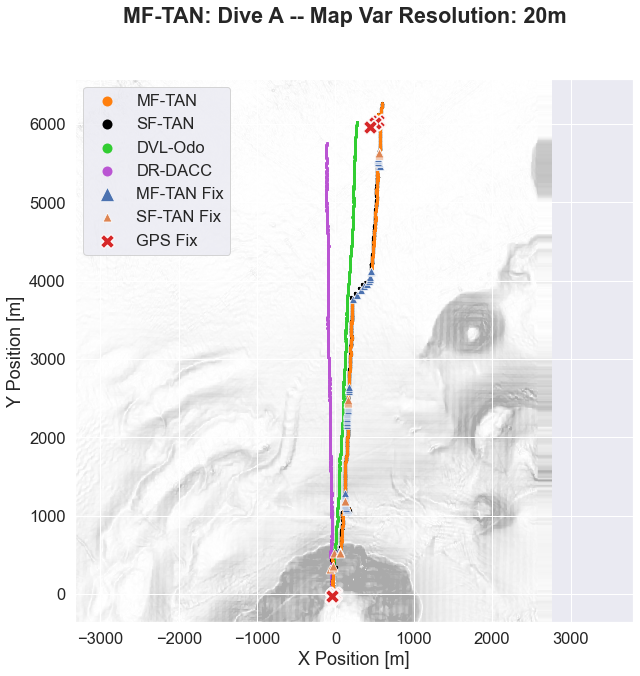

> New pitch, roll, and heading data extracted!
> Finished Estimating Water Column Currents!
> Finished Calculating Odometry!
> Finished Multi-Factor Terrain-Aided Navigation!
Dive: E
  Range:   866
  DR-DACC: 66.3
  DVL-Odo: 31.3
  MF-TAN:  18.8


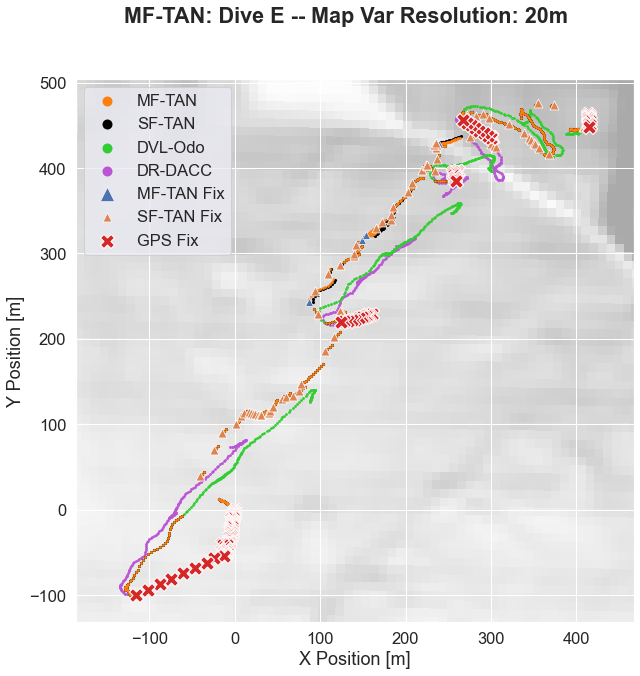

> New pitch, roll, and heading data extracted!
> Finished Estimating Water Column Currents!
> Finished Calculating Odometry!
> Finished Multi-Factor Terrain-Aided Navigation!
Dive: F
  Range:   876
  DR-DACC: 59.9
  DVL-Odo: 35.5
  MF-TAN:  17.9


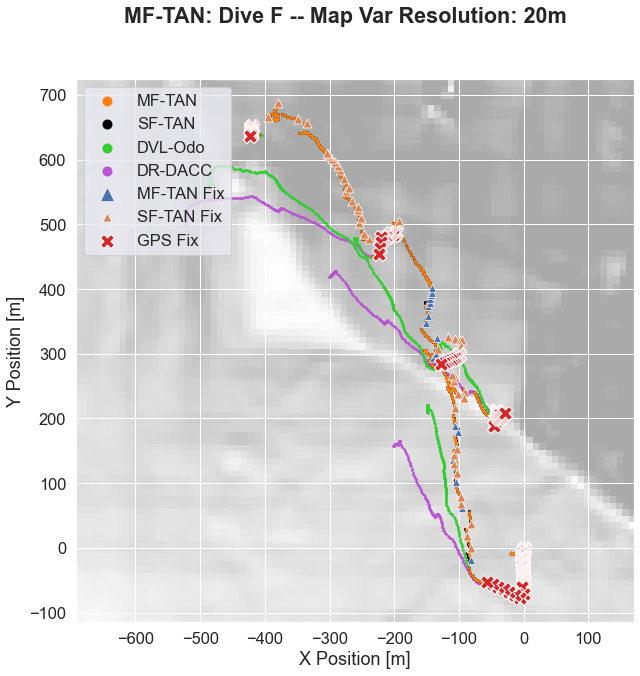

> New pitch, roll, and heading data extracted!
> Finished Estimating Water Column Currents!
> Finished Calculating Odometry!
> Finished Multi-Factor Terrain-Aided Navigation!
Dive: G
  Range:   503
  DR-DACC: 28.8
  DVL-Odo: 25.1
  MF-TAN:  9.8


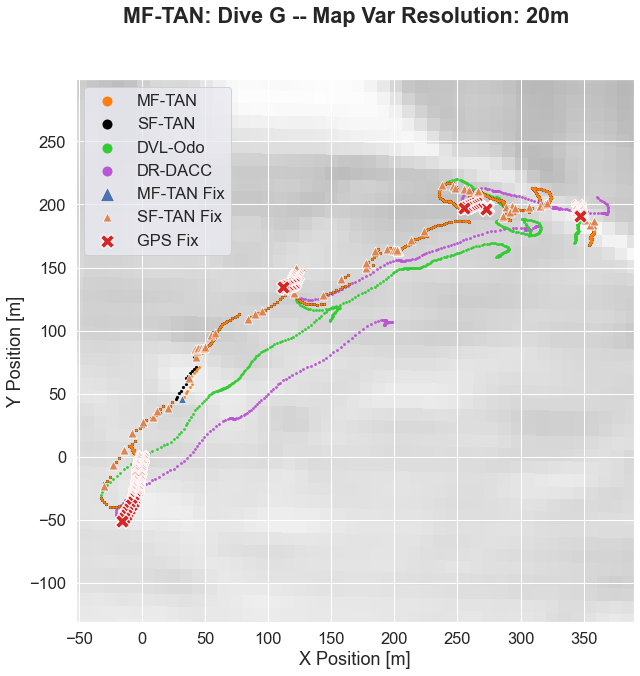

In [283]:
list_dives = [tsa, tse, tsf, tsg]
#
# for DEPTH_NOISE_FACTOR in sensitivity_test_list: 
if True: #For when you don'w want to run sensitivity tests

    def generateTAU(depth_var, slope_var, orient_var):
        DEPTH_NOISE_FACTOR =  0 # [m] (6 magic number for dive A specifically)
        SLOPE_NOISE_FACTOR =  2.5 # [deg]
        ORIENT_NOISE_FACTOR = 12 # [deg] 
        TAU_DEPTH  = np.sqrt(depth_var)*3 + DEPTH_NOISE_FACTOR
        TAU_SLOPE  = np.sqrt(slope_var)*3 + SLOPE_NOISE_FACTOR
        TAU_ORIENT = np.sqrt(orient_var)*0.5 + ORIENT_NOISE_FACTOR

        return TAU_DEPTH, TAU_SLOPE, TAU_ORIENT
    dvl_odo_composite_error = []
    mf_tan_composite_error = []

    for ts in list_dives:
        ##Time Synchronization Fix
        #extract the relevant portion of the glider flight computer
        start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
        end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
        dur     = end_t - start_t 
        df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

        RAD_TO_DEG = 180/np.pi
        new_pitch_list = [] 
        new_roll_list = []
        new_heading_list = []

        for t in range(len(ts.df)):
            # extract timestamp from PD0 file and corresponding sections of DBD file
            time   = ts.df.time[t]
            target = datetime.datetime.fromtimestamp(time)
            lower  = df_dbd[:str(target)]
            upper  = df_dbd[str(target):]

            # handle edge cases when interpolation is not possible  
            if len(lower)==0:
                new_pitch_list.append(upper.m_pitch[0]*RAD_TO_DEG)
                new_roll_list.append(upper.m_roll[0]*RAD_TO_DEG)
                new_heading_list.append(upper.m_heading[0]*RAD_TO_DEG)
                continue
            if len(upper)==0:
                new_pitch_list.append(lower.m_pitch[-1]*RAD_TO_DEG)
                new_roll_list.append(lower.m_roll[-1]*RAD_TO_DEG)
                new_heading_list.append(lower.m_heading[-1]*RAD_TO_DEG)
                continue 

            lower_time  = lower.time[-1]
            lower_pitch = lower.m_pitch[-1]
            lower_roll  = lower.m_roll[-1]
            lower_heading   = lower.m_heading[-1]
            upper_time  = upper.time[0]
            upper_pitch = upper.m_pitch[0]
            upper_roll  = upper.m_roll[0]
            upper_heading   = upper.m_heading[0]
            delta_t     = upper_time-lower_time

            # case when DBD data is repeated in successive timestamps
            if delta_t == 0:
                new_pitch_list.append(lower.m_pitch[-1]*RAD_TO_DEG)
                new_roll_list.append(lower.m_roll[-1]*RAD_TO_DEG)
                new_heading_list.append(lower.m_heading[-1]*RAD_TO_DEG)
                continue

            # take linear interpolation between DBD values
            lower_per   = (time-lower_time)/delta_t
            upper_per   = 1 - lower_per
            new_pitch   = lower_pitch*lower_per + upper_pitch*upper_per
            new_pitch_list.append(new_pitch*RAD_TO_DEG)
            new_roll   = lower_roll*lower_per + upper_roll*upper_per
            new_roll_list.append(new_roll*RAD_TO_DEG)
            new_heading   = lower_heading*lower_per + upper_heading*upper_per
            new_heading_list.append(new_heading*RAD_TO_DEG)

        ts.df['pitch'] = new_pitch_list
        ts.df['roll']  = new_roll_list
        ts.df['heading']   = new_heading_list
        print('> New pitch, roll, and heading data extracted!')

        ##Compute Water Column CUrrents
        # tuning parameters for working with DVL data 
        pitch_bias           =  8    # [deg]   mounting pitch bias for the sonar
        start_filter         =  2    # [bin #] avoid using the first number of bins
        end_filter           =  2    # [bin #] avoid using the last number of bins 
        voc_mag_filter       =  1.0  # [m/s]   filter out ocean current 
        voc_delta_mag_filter =  0.5  # [m/s]   filter out deltas between layers
        near_surface_filter  = 10    # [m]     ignore Vtw when near surface 

        # constants
        DEG_TO_RAD = np.pi/180

        # determine DVL parameters 
        bin_len      = ts.df.depth_bin_length[0]
        bin0_dist    = ts.df.bin0_distance[0]
        bin_len      = np.cos(pitch_bias*DEG_TO_RAD)*bin_len
        bin0_dist    = np.cos(pitch_bias*DEG_TO_RAD)*bin0_dist
        max_range    = 80
        max_depth    = int(np.max(ts.df.depth)+80)
        x_beam       = 0
        y_beam       = 1

        # intialize water column
        water_column = VelocityShearPropagation.WaterColumn(
            bin_len=bin_len, 
            bin0_dist=bin0_dist,
            max_depth=max_depth,
            start_filter=start_filter,
            end_filter=end_filter,
            voc_mag_filter=voc_mag_filter,
            voc_delta_mag_filter=voc_delta_mag_filter,
        )

        # iterate over the DVL ensembles 
        for t in range(len(ts.df)):

            # only use Vtw from pressure sensor when submerged 
            depth = ts.df.depth[t]
            pitch = ts.df.pitch[t]
            roll  = ts.df.roll[t]
            if depth > near_surface_filter:
                vtw_u = ts.df.rel_vel_pressure_u[t]
                vtw_v = ts.df.rel_vel_pressure_v[t]

            # otherwise use the DVL to estimate the Vtw at the surface
            else:
                vtw_u = ts.df.rel_vel_dvl_u[t]
                vtw_v = ts.df.rel_vel_dvl_v[t]

            # extract Voc reference from bottom track velocity when available
            if not np.isnan(ts.df.abs_vel_btm_u[t]):
                vog_u = ts.df.abs_vel_btm_u[t]
                vog_v = ts.df.abs_vel_btm_v[t]
                voc_u = vog_u - vtw_u
                voc_v = vog_v - vtw_v
                voc_ref = VelocityShearPropagation.OceanCurrent(voc_u, voc_v, 0)
            else:
                voc_ref = VelocityShearPropagation.OceanCurrent()

            # add shear nodes for each DVL depth bin that meet the filter criteria
            num_good_vel_bins = ts.df.num_good_vel_bins[t]
            if num_good_vel_bins > start_filter+end_filter:        

                # determine if glider ascending or descending
                delta_z = ts.df.delta_z[t]
                if delta_z > 0:
                    direction = 'descending'
                else:
                    direction = 'ascending'

                # build list of velocity shears to add as ShearNode to water column
                delta_voc_u = []
                delta_voc_v = []

                # add all valid DVL bins to the shear list 
                #   + filtering of DVL bins will occur in the `add_shear_node` call
                for bin_num in range(int(num_good_vel_bins)):

                    # retrieve the shear list from the DVL data 
                    x_var = ts.get_profile_var_name('velocity', bin_num, x_beam)
                    y_var = ts.get_profile_var_name('velocity', bin_num, y_beam)
                    dvl_x = ts.df[x_var][t]
                    dvl_y = ts.df[y_var][t]

                    # compute delta between dead-reckoned through-water velocity & DVL
                    delta_voc_u.append(vtw_u - (-dvl_x))
                    delta_voc_v.append(vtw_v - (-dvl_y))

                shear_list = [VelocityShearPropagation.OceanCurrent(
                                delta_voc_u[i], 
                                delta_voc_v[i], 
                                0) 
                              for i in range(len(delta_voc_u))]

                # add shear node to the water column with shear list information 
                if len(shear_list):
                    water_column.add_shear_node(
                        z_true=depth,
                        t=t,
                        shear_list=shear_list,
                        voc_ref=voc_ref,
                        direction=direction,
                        pitch=pitch,
                        roll=roll,
                    )

            # add voc_ref measurement to the water column even if shear list is empty  
            elif not voc_ref.is_none():
                water_column.add_shear_node(
                    z_true=depth,
                    t=t,
                    shear_list=[],
                    voc_ref=voc_ref,
                    direction=direction,
                    pitch=pitch,
                    roll=roll,
                )

        voc_u_list,voc_v_list,voc_w_list,voc_z_list = water_column.compute_averages()
        print("> Finished Estimating Water Column Currents!")

        ##Compute DVL-Odometry
        # initialize list for new odometry
        rel_pos_x = [0]
        rel_pos_y = [0]
        rel_pos_z = [0]
        delta_x_list = [0]
        delta_y_list = [0]

        vel_list_x = []
        vel_list_y = []
        u_list     = []
        v_list     = []
        # set flag for setting GPS updates
        flag_gps_fix_at_surface = False 

        # extract the relevant portion of the glider flight computer
        start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
        end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
        dur     = end_t - start_t 
        df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

        # extract start_t position "origin" from the glider flight data 
        for t in range(len(df_dbd)):
            if not np.isnan(df_dbd.m_x_lmc[t]):
                dbd_origin_x = df_dbd.m_x_lmc[t]
                dbd_origin_y = df_dbd.m_y_lmc[t]
                break

        # iterate through the dive file to update odometry
        for t in range(1,len(ts.df)):
            time    = ts.df.time[t]
            prev_x  = rel_pos_x[-1]
            prev_y  = rel_pos_y[-1]
            delta_t = ts.df.delta_t[t]
            depth   = ts.df.depth[t]

            # only use Vtw from pressure sensor when submerged 
            depth = ts.df.depth[t]
            if depth > near_surface_filter:
                vtw_u = ts.df.rel_vel_pressure_u[t]
                vtw_v = ts.df.rel_vel_pressure_v[t]
                flag_gps_fix_at_surface = False
            # otherwise use the DVL to estimate the Vtw at the surface
            else:
                vtw_u = ts.df.rel_vel_dvl_u[t]
                vtw_v = ts.df.rel_vel_dvl_v[t]

            # retrieve over ground velocity from DVL in bottom track 
            vog_u = ts.df.abs_vel_btm_u[t]
            vog_v = ts.df.abs_vel_btm_v[t]

            #################################################################
            # retrieve ocean current estimate from water column 
            #voc_u = voc_u_list[int(depth)]
            #voc_v = voc_v_list[int(depth)]
            good_node_list = []
            count = 0
            cum_voc_u = 0
            cum_voc_v = 0
            # Extract all shear nodes at current depth
            wc_depth = water_column.get_wc_bin(depth)
            node_list = water_column.get_voc_at_depth(wc_depth)

            #Iterate through shear nodes at depth
            for shear_node in node_list:
                voc = shear_node.voc
                if not(voc.is_none()):
                    # filter out large values when computing averages
                    if voc.mag < voc_mag_filter:
                        good_node_list.append(shear_node)
        ########################################################################
            if (len(good_node_list) > 0):
                    for i in range(len(good_node_list)):
                        if i == 0:
                            count += 1
                            cum_voc_u += good_node_list[0].voc.u
                            cum_voc_v += good_node_list[0].voc.v
                        elif (i <= MIN_NUM_NODES):
                            count += 1
                            cum_voc_u += good_node_list[i].voc.u
                            cum_voc_v += good_node_list[i].voc.v
                        else: 
                            time_between_current_estimates = good_node_list[i].t - good_node_list[0].t
                            if time_between_current_estimates > (ocean_current_time_filter*60):
                                count += 1 
                                cum_voc_u += good_node_list[i].voc.u
                                cum_voc_v += good_node_list[i].voc.v
                    #voc_avg = OceanCurrent(cum_voc_u/count, cum_voc_v/count, 0)
                    voc_u = cum_voc_u/count
                    voc_v = cum_voc_v/count
                    u_list.append(voc_u)
                    v_list.append(voc_v)
        ####################################################################                
            else:
                voc_u = np.nan
                voc_v = np.nan
                u_list.append(voc_u)
                v_list.append(voc_v)

            #################################################################
            # initialize delta values to zero
            delta_x, delta_y = 0,0

            # CASE 1: use bottom track overground velocity if available
            if (not np.isnan(vog_u)):
                delta_x = vog_u*delta_t
                delta_y = vog_v*delta_t
                vel_list_x.append(vog_u)
                vel_list_y.append(vog_v)

            # CASE 2: use through water velocity and ocean current estimate if available
            elif (not np.isnan(vtw_u)) and (not np.isnan(voc_u)):
                    delta_x = (vtw_u + voc_u)*delta_t
                    delta_y = (vtw_v + voc_v)*delta_t
                    vel_list_x.append(vtw_u + voc_u)
                    vel_list_y.append(vtw_v + voc_v)
            # CASE 3: use through water velocity if available
            elif (not np.isnan(vtw_u)):
                    delta_x = vtw_u*delta_t
                    delta_y = vtw_v*delta_t
                    vel_list_x.append(vtw_u)
                    vel_list_y.append(vtw_v)
            # CASE 4: use ocean current estimate if available
            elif (not np.isnan(voc_u)):
                    delta_x = voc_u*delta_t
                    delta_y = voc_v*delta_t
                    vel_list_x.append(voc_u)
                    vel_list_y.append(voc_v)

            # set current position to DVL odometry result 
            cur_x = delta_x + prev_x
            cur_y = delta_y + prev_y

            # override current position if GPS fix is given 
            if depth < near_surface_filter:
                cur_time = datetime.datetime.fromtimestamp(time)
                cur_dbd  = df_dbd[str(cur_time):].copy()
                if (len(cur_dbd.m_gps_x_lmc) != 0):
                    if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                        cur_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x
                        cur_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y
                        flag_gps_fix_at_surface = True

                        vel_list_x.append(cur_dbd.m_vx_lmc[0])
                        vel_list_y.append(cur_dbd.m_vy_lmc[0])

            # update the odometry list of positions
            rel_pos_x.append(cur_x)
            rel_pos_y.append(cur_y)
            rel_pos_z.append(depth)
            delta_x_list.append(delta_x)
            delta_y_list.append(delta_y)

        # add new odomety to the data frame
        ts.df['rel_pos_x'] = rel_pos_x
        ts.df['rel_pos_y'] = rel_pos_y
        ts.df['rel_pos_z'] = rel_pos_z
        ts.df['delta_x']   = delta_x_list
        ts.df['delta_y']   = delta_y_list

        print("> Finished Calculating Odometry!")
        ##MF-TAN
        def get_utm_coords_from_glider_lat_lon(m_lat, m_lon):
            SECS_IN_MIN = 60
            MIN_OFFSET = 100
            lat_min  = m_lat % MIN_OFFSET 
            lon_min  = m_lon % MIN_OFFSET 
            lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
            lon_dec  = (m_lon - lon_min)/MIN_OFFSET + lon_min/SECS_IN_MIN
            utm_pos  = utm.from_latlon(lat_dec, lon_dec)
            easting  = round(utm_pos[0],2)
            northing = round(utm_pos[1],2)
            zone     = utm_pos[2]
            zone_letter  = utm_pos[3]
            return(easting, northing, zone, zone_letter)

        # constants
        JANUS_ANGLE = 30
        DEG_TO_RAD  = np.pi/180
        RAD_TO_DEG  = 1/DEG_TO_RAD
        sin_janus   = np.sin(JANUS_ANGLE*DEG_TO_RAD)
        cos_janus   = np.cos(JANUS_ANGLE*DEG_TO_RAD)
        min_valid_slant_ranges = 3 

        # AUG parameters
        BIAS_PITCH   = 12.5  # [deg]
        BIAS_ROLL    =  0.0  # [deg]
        BIAS_HEADING =  0.0  # [deg]

        # heading offsets for the four DVL beams
        beam_heading_offsets = {
            0 : -90, # 0 = Port
            1 :  90, # 1 = Starboard
            2 :   0, # 2 = Forward
            3 : 180, # 3 = Aft
        }


        # intialize point cloud object 
        pc = MultiFactorTAN.PointCloud(grid_res_num)
        pc_bathy_depth  = [np.nan]
        pc_bathy_slope  = [np.nan]
        pc_bathy_orient = [np.nan]
        MFTAN_depth  = np.array(bathy_df.depth_list)
        MFTAN_slope  = np.array(bathy_df.slope_list)
        MFTAN_orient = np.array(bathy_df.orient_list)


        # initialize list to keep track of TAN information
        tan_pos_x = [0]
        tan_pos_y = [0]
        tan_pos_z = [0]
        tan_pos_r = [0]
        dvl_pos_r = [0]
        sf_tan_pos_x = [0]
        sf_tan_pos_y = [0]
        tan_update_x = []
        tan_update_y = []
        tan_update_t = []
        tan_update_index  = [] 
        tan_update_x_SF = []
        tan_update_y_SF = []
        tan_update_t_SF = []
        tan_update_index_SF  = [] 
        tan_update_depth  = []
        tan_update_slope  = []
        tan_update_orient = []


        # extract the relevant portion of the glider flight computer
        start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
        end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
        dur     = end_t - start_t 
        df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

        # extract start_t position "origin" from the glider flight data 
        for t in range(len(df_dbd)):
            if not np.isnan(df_dbd.m_x_lmc[t]):
                dbd_origin_x_lmc = df_dbd.m_x_lmc[t]
                dbd_origin_y_lmc = df_dbd.m_y_lmc[t]
                dbd_origin_m_lat = df_dbd.m_lat[t]
                dbd_origin_m_lon = df_dbd.m_lon[t]
                break

        dbd_utm_x, dbd_utm_y, _, zone_letter = get_utm_coords_from_glider_lat_lon(
            dbd_origin_m_lat, 
            dbd_origin_m_lon
        )

        ##Adaptive TAU Testing Logs##
        depth_var_list  = []
        slope_var_list  = []
        orient_var_list = []
        utm_est_x_list  = []
        utm_est_y_list  = []
        #############################

        # iterate over length of Dive 
        for t in range(1,len(ts.df)):

            # retrieve previous position information
            time    = ts.df.time[t]
            prev_x  = tan_pos_x[-1]
            prev_y  = tan_pos_y[-1]
            prev_r  = tan_pos_r[-1]
            delta_t = ts.df.delta_t[t]
            depth   = ts.df.depth[t]
            delta_x = ts.df.delta_x[t]
            delta_y = ts.df.delta_y[t]
            delta_r = np.linalg.norm([delta_x, delta_y])
            sf_prev_x  = sf_tan_pos_x[-1]
            sf_prev_y  = sf_tan_pos_y[-1]

            # retrieve DVL odometry update for case when TAN fix not available
            dvl_odo_x = prev_x + delta_x
            dvl_odo_y = prev_y + delta_y
            sf_dvl_odo_x = sf_prev_x + delta_x
            sf_dvl_odo_y = sf_prev_y + delta_y
            dvl_odo_r = prev_r + delta_r*DVL_ODO_DRIFT
            dvl_pos_r.append(dvl_pos_r[-1]+delta_r*DVL_ODO_DRIFT)

            # extract slant ranges 
            slant_ranges = {
                0 : ts.df.btm_beam0_range[t] / cos_janus, # 0 = Port 
                1 : ts.df.btm_beam1_range[t] / cos_janus, # 1 = Starboard
                2 : ts.df.btm_beam2_range[t] / cos_janus, # 2 = Forward  
                3 : ts.df.btm_beam3_range[t] / cos_janus, # 3 = Aft 
            }

            # ignore case when less than three ranges are available
            valid_slant_ranges = {key:slant_ranges[key] for key in 
                slant_ranges.keys() if not np.isnan(slant_ranges[key])}

            # extract current AUV position in LMC coordinates
            aug_x = ts.df.rel_pos_x[t]
            aug_y = ts.df.rel_pos_y[t]
            aug_z = ts.df.rel_pos_z[t]
            aug_heading = ts.df.heading[t]
            aug_pitch   = ts.df.pitch[t]
            aug_roll    = ts.df.roll[t]

            # override current position if GPS fix is given 
            if depth < near_surface_filter:
                cur_time = datetime.datetime.fromtimestamp(time)
                cur_dbd  = df_dbd[str(cur_time):].copy()
                if (len(cur_dbd.m_gps_x_lmc) != 0):
                    if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                        gps_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x
                        gps_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y
                        flag_gps_fix_at_surface = True
                        pc_bathy_depth.append(np.nan)
                        pc_bathy_slope.append(np.nan)
                        pc_bathy_orient.append(np.nan)
                        tan_pos_x.append(gps_x)
                        tan_pos_y.append(gps_y)
                        tan_pos_z.append(depth)
                        sf_tan_pos_x.append(gps_x)
                        sf_tan_pos_y.append(gps_y)
                        new_r = np.min([prev_r*0.5, 50])
                        tan_pos_r.append(prev_r)
                        continue

            # ignore case when 3 or less slant ranges are present
            # ignore case when glider is not sufficiently pitched
            #######################################Pose Filter##################### REMOVED
            if (len(valid_slant_ranges) < min_valid_slant_ranges): #or (abs(aug_pitch) < pc.MIN_PITCH)):
                pc_bathy_depth.append(np.nan)
                pc_bathy_slope.append(np.nan)
                pc_bathy_orient.append(np.nan)
                tan_pos_x.append(dvl_odo_x)
                tan_pos_y.append(dvl_odo_y)
                tan_pos_z.append(depth)
                tan_pos_r.append(dvl_odo_r)
                sf_tan_pos_x.append(sf_dvl_odo_x)
                sf_tan_pos_y.append(sf_dvl_odo_y)
                continue

            # compute rotation matrices to go from instrument coords to earth coords
            aug_Qx = pc.Qx((aug_pitch   + BIAS_PITCH)   * DEG_TO_RAD)
            aug_Qy = pc.Qy((aug_roll    + BIAS_ROLL)    * DEG_TO_RAD)
            aug_Qz = pc.Qz((aug_heading + BIAS_HEADING) * DEG_TO_RAD)

            # extract bottom contact positions in Earth coordinate frame
            point_cloud = []
            for beam in valid_slant_ranges:
                r = valid_slant_ranges[beam]
                z = r*cos_janus  # vertical component 
                h = r*sin_janus  # horizontal component

                # get bottom contact in instrument coordinates
                beam_heading = beam_heading_offsets[beam]
                x  = h*np.sin(beam_heading*DEG_TO_RAD)
                y  = h*np.cos(beam_heading*DEG_TO_RAD)
                z *= -1  # z is positive upwards for rotation

                # rotate into Ship coordinates
                # + ship coordinates is a horizontal translation away from Earth coordinates
                inst_pos = np.array([[x], [y], [z]])
                ship_pos = np.dot(aug_Qz, np.dot(aug_Qy, np.dot(aug_Qx, inst_pos)))
                x,y,z    = tuple(ship_pos.flatten())
                z       *= -1  # z is positive downwards again

                # add to the point cloud
                # + keep track of ship coordinates for debugging purposes
                bt_point = MultiFactorTAN.BottomTrackPoint(t, beam, x, y, z, aug_x, aug_y, aug_z)
                pc.add_point(bt_point)

            # get the three bathymetry factors from the point cloud
            bathy_depth, bathy_slope, bathy_orient = pc.get_factors()
            pc_bathy_depth.append(bathy_depth)
            pc_bathy_slope.append(bathy_slope)
            pc_bathy_orient.append(bathy_orient)

            # update use DVL-Odometry update when no features are available
            # + navigation uncertainty r grows as a function of distance traveled
            if np.isnan(bathy_depth):
                tan_pos_x.append(dvl_odo_x)
                tan_pos_y.append(dvl_odo_y)
                tan_pos_z.append(depth)
                tan_pos_r.append(dvl_odo_r)
                sf_tan_pos_x.append(sf_dvl_odo_x)
                sf_tan_pos_y.append(sf_dvl_odo_y)
                continue

            ###########################################
            #       Adaptive Tau Process *TESTING*    #
            ###########################################
            def find_nearest(array1, value1, array2, value2):
                array1 = np.asarray(array1)
                array2 = np.asarray(array2)
                idx = (np.abs(array1 - value1) + np.abs(array2-value2)).argmin()
                return idx

            def findVar_fromMap(x, y, df):

                idx = find_nearest(df.utm_x_list, x, df.utm_y_list, y)

                depth_var  = df.depth_var[idx]
                slope_var  = df.slope_var[idx]
                orient_var = df.orient_var[idx]
                return depth_var, slope_var, orient_var

            cur_utm_est_x = dbd_utm_x + dvl_odo_x
            cur_utm_est_y = dbd_utm_y + dvl_odo_y

            cur_depth_var, cur_slope_var, cur_orient_var = findVar_fromMap(cur_utm_est_x, cur_utm_est_y, bathy_df_var)


            TAU_DEPTH, TAU_SLOPE, TAU_ORIENT = generateTAU(cur_depth_var, cur_slope_var, cur_orient_var)

            depth_var_list.append(TAU_DEPTH)
            slope_var_list.append(TAU_SLOPE)
            orient_var_list.append(TAU_ORIENT)
            utm_est_x_list.append(cur_utm_est_x)
            utm_est_y_list.append(cur_utm_est_y)
            ############################################

            # use factors to help limit navigation error 
            MFTAN_factors = np.array(bathy_df.depth_list)
            MFTAN_factors[MFTAN_depth > bathy_depth+TAU_DEPTH] = np.nan
            MFTAN_factors[MFTAN_depth < bathy_depth-TAU_DEPTH] = np.nan
            MFTAN_factors[MFTAN_slope > bathy_slope+TAU_SLOPE] = np.nan
            MFTAN_factors[MFTAN_slope < bathy_slope-TAU_SLOPE] = np.nan
            MFTAN_factors[MFTAN_orient > bathy_orient+TAU_ORIENT] = np.nan
            MFTAN_factors[MFTAN_orient < bathy_orient-TAU_ORIENT] = np.nan

            # Single-Factor TAN equivalent
            SFTAN_factors = np.array(bathy_df.depth_list)
            SFTAN_factors[MFTAN_depth > bathy_depth+TAU_DEPTH] = np.nan
            SFTAN_factors[MFTAN_depth < bathy_depth-TAU_DEPTH] = np.nan

            MFTAN_factors[((bathy_df.utm_x_list - dbd_utm_x - prev_x)**2 + 
                           (bathy_df.utm_y_list - dbd_utm_y - prev_y)**2)**0.5 > prev_r] = np.nan
            SFTAN_factors[((bathy_df.utm_x_list - dbd_utm_x - prev_x)**2 + 
                           (bathy_df.utm_y_list - dbd_utm_y - prev_y)**2)**0.5 > prev_r] = np.nan

            MFTAN_factors = np.array(MFTAN_factors)
            SFTAN_factors = np.array(SFTAN_factors)
            idx           = np.argwhere(np.isfinite(MFTAN_factors)).flatten()
            SF_idx        = np.argwhere(np.isfinite(SFTAN_factors)).flatten()

            # if match found, update pos and reduce uncertainty 
            # + possibly expand uncertainty range to sett if fix is available?
            if len(idx) > 0:
                MFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in idx]) - dbd_utm_x
                MFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in idx]) - dbd_utm_y

                ODO_WEIGHT = 1-TAN_WEIGHT
                new_x   = ODO_WEIGHT*dvl_odo_x + TAN_WEIGHT*MFTAN_x
                new_y   = ODO_WEIGHT*dvl_odo_y + TAN_WEIGHT*MFTAN_y
                tan_pos_x.append(new_x)
                tan_pos_y.append(new_y)
                tan_pos_z.append(depth)
                tan_pos_r.append(prev_r*TAN_RED_DRIFT)

                # store TAN fix information for plotting utilities
                tan_update_x.append(new_x)
                tan_update_y.append(new_y)
                tan_update_t.append(ts.df.time[t])
                tan_update_index.append(t)
                tan_update_depth.append(bathy_depth)
                tan_update_slope.append(bathy_slope)
                tan_update_orient.append(bathy_orient)


            # not matches with MF-TAN, use SF-TAN or DVL-Odometry if necessary
            else:
                if len(SF_idx) > 0:
                    MFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in SF_idx]) - dbd_utm_x
                    MFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in SF_idx]) - dbd_utm_y
                    ODO_WEIGHT = 1-TAN_WEIGHT
                    new_x   = ODO_WEIGHT*dvl_odo_x + TAN_WEIGHT*MFTAN_x
                    new_y   = ODO_WEIGHT*dvl_odo_y + TAN_WEIGHT*MFTAN_y

                    tan_pos_x.append(new_x)
                    tan_pos_y.append(new_y)
                    tan_pos_z.append(depth)
                    tan_pos_r.append(prev_r*TAN_RED_DRIFT)

                    # store TAN fix information for plotting utilities
                    tan_update_x_SF.append(new_x)
                    tan_update_y_SF.append(new_y)
                    tan_update_t_SF.append(ts.df.time[t])
                    tan_update_index_SF.append(t)
                    tan_update_depth.append(bathy_depth)
                    tan_update_slope.append(bathy_slope)
                    tan_update_orient.append(bathy_orient)

                # otherwise use DVL 
                else:
                    tan_pos_x.append(dvl_odo_x)
                    tan_pos_y.append(dvl_odo_y)
                    tan_pos_z.append(depth)
                    tan_pos_r.append(dvl_odo_r)


            # if match found, update pos and reduce uncertainty 
            # + possibly expand uncertainty range to sett if fix is available?
            if len(SF_idx) > 0:
                SFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in SF_idx]) - dbd_utm_x
                SFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in SF_idx]) - dbd_utm_y
                ODO_WEIGHT = 1-TAN_WEIGHT
                new_x   = ODO_WEIGHT*sf_dvl_odo_x + TAN_WEIGHT*SFTAN_x
                new_y   = ODO_WEIGHT*sf_dvl_odo_y + TAN_WEIGHT*SFTAN_y
                sf_tan_pos_x.append(new_x)
                sf_tan_pos_y.append(new_y)

            # not matches with MF-TAN -- update using DVL-odometry
            else:
                sf_tan_pos_x.append(sf_dvl_odo_x)
                sf_tan_pos_y.append(sf_dvl_odo_y)


        # add seafloor factors to the dataframe
        pc_bathy_depth  = np.array(pc_bathy_depth)
        pc_bathy_slope  = np.array(pc_bathy_slope)
        pc_bathy_orient = np.array(pc_bathy_orient)
        ts.df.pc_bathy_depth  = pc_bathy_depth
        ts.df.pc_bathy_slope  = pc_bathy_slope
        ts.df.pc_bathy_orient = pc_bathy_orient

        # add new odomety to the data frame
        ts.df['tan_pos_x'] = tan_pos_x
        ts.df['tan_pos_y'] = tan_pos_y
        ts.df['tan_pos_z'] = tan_pos_z
        ts.df['tan_pos_r'] = tan_pos_r

        print("> Finished Multi-Factor Terrain-Aided Navigation!")

        ##Performance Analysis (show results)
        if show_results: 
            # Quantify Performance of DR-DACC, DVL-ODO, and MF-TAN
            #%% Extract last gps fix before start of dive and first gps fix when surfacing from a dive
            surface_flag = False
            depth_cutoff = 5
            DBD_start_stop_points_idx = []
            for i in range(1, len(df_dbd.m_depth) - 2):
                if not np.isnan(df_dbd.m_gps_x_lmc[i]) and surface_flag is False:
                    surface_flag = True
                    DBD_start_stop_points_idx.append(i)
                elif not np.isnan(df_dbd.m_gps_x_lmc[i]) and np.isnan(df_dbd.m_gps_x_lmc[i+1]) and np.isnan(df_dbd.m_gps_x_lmc[i+2]) and surface_flag is True:
                        DBD_start_stop_points_idx.append(i)
                        surface_flag = False

            DBD_start_stop_points_idx_cut = DBD_start_stop_points_idx[1:-1]

            #%% Reconcile Glider Log timestamp to DVL timestamp and extract DVL-ODO and MF-TAN Nav start_stop points
            DVL_start_stop_times = []
            for idx in DBD_start_stop_points_idx_cut:
                DVL_start_stop_times.append(datetime.datetime.fromtimestamp(df_dbd.time[idx])) 
            # print(DVL_start_stop_times)

            DBD_start_stop_points_idx_cut = DBD_start_stop_points_idx[1:-1]

            nav = {
                'dive' : {
                    'gps_x' : [],
                    'gps_y' : [],

                    'dac_x' : [],
                    'dac_y' : [],

                    'odo_x' : [],
                    'odo_y' : [],

                    'tan_x' : [],
                    'tan_y' : [],
                }
            }

            origin_x = dbd_origin_x_lmc
            origin_y = dbd_origin_y_lmc

            for idx in DBD_start_stop_points_idx_cut:
                nav['dive']['gps_x'].append(df_dbd.m_gps_x_lmc[idx] - origin_x)
                nav['dive']['gps_y'].append(df_dbd.m_gps_y_lmc[idx] - origin_y)
            dac_delay = 1
            for i in range(0, len(DBD_start_stop_points_idx_cut)):
                if i %2 == 0:
                    nav['dive']['dac_x'].append(df_dbd.m_x_lmc[DBD_start_stop_points_idx_cut[i]] - origin_x)
                    nav['dive']['dac_y'].append(df_dbd.m_y_lmc[DBD_start_stop_points_idx_cut[i]] - origin_y)
                else:
                    if not np.isnan(df_dbd.m_x_lmc[DBD_start_stop_points_idx_cut[i]-dac_delay] - origin_x):
                        dac_x_temp = df_dbd.m_x_lmc[DBD_start_stop_points_idx_cut[i]-dac_delay] - origin_x
                        dac_y_temp = df_dbd.m_y_lmc[DBD_start_stop_points_idx_cut[i]-dac_delay] - origin_y
                    else:
                        for j in range(DBD_start_stop_points_idx_cut[i]-dac_delay, 0, -1):
                            if not np.isnan(df_dbd.m_x_lmc[j] - origin_x):
                                dac_x_temp = df_dbd.m_x_lmc[j] - origin_x
                                dac_y_temp = df_dbd.m_y_lmc[j] - origin_y
                                break
                    nav['dive']['dac_x'].append(dac_x_temp)
                    nav['dive']['dac_y'].append(dac_y_temp)

            DVL_start = 0
            DVL_end = -10
            for i in range(1, len(DVL_start_stop_times),2):
                ts_temp = (ts.df[str(DVL_start_stop_times[i-1]):str(DVL_start_stop_times[i])].copy())
                nav['dive']['odo_x'].append(ts_temp.rel_pos_x[DVL_start])
                nav['dive']['odo_y'].append(ts_temp.rel_pos_y[DVL_start])
                nav['dive']['odo_x'].append(ts_temp.rel_pos_x[DVL_end])
                nav['dive']['odo_y'].append(ts_temp.rel_pos_y[DVL_end])
                nav['dive']['tan_x'].append(ts_temp.tan_pos_x[DVL_start])
                nav['dive']['tan_y'].append(ts_temp.tan_pos_y[DVL_start])
                nav['dive']['tan_x'].append(ts_temp.tan_pos_x[DVL_end])
                nav['dive']['tan_y'].append(ts_temp.tan_pos_y[DVL_end])

            nav_range = [] 
            dac_error = []
            odo_error = []
            tan_error = []
            if ts == tsa:
                ## Needed for only dive A --> to fix, would need to automate counting how many actual dives "legs" there are
                for leg in range(1,2): 
                    delta_gps_x = nav['dive']['gps_x'][leg] - nav['dive']['gps_x'][leg-1]
                    delta_gps_y = nav['dive']['gps_y'][leg] - nav['dive']['gps_y'][leg-1]
                    delta_gps   = np.linalg.norm([delta_gps_x, delta_gps_y])
                    nav_range.append(delta_gps)

                    delta_dac_x = nav['dive']['dac_x'][leg] - nav['dive']['gps_x'][leg]
                    delta_dac_y = nav['dive']['dac_y'][leg] - nav['dive']['gps_y'][leg]
                    delta_dac   = np.linalg.norm([delta_dac_x, delta_dac_y])
                    dac_error.append(delta_dac)

                    delta_odo_x = nav['dive']['odo_x'][leg] - nav['dive']['gps_x'][leg]
                    delta_odo_y = nav['dive']['odo_y'][leg] - nav['dive']['gps_y'][leg]
                    delta_odo   = np.linalg.norm([delta_odo_x, delta_odo_y])
                    odo_error.append(delta_odo)

                    delta_tan_x = nav['dive']['tan_x'][leg] - nav['dive']['gps_x'][leg]
                    delta_tan_y = nav['dive']['tan_y'][leg] - nav['dive']['gps_y'][leg]
                    delta_tan   = np.linalg.norm([delta_tan_x, delta_tan_y])
                    tan_error.append(delta_tan)

                mission_range = sum(nav_range)
                dive_label = 'A'
                print('Dive: A')
                print('  Range:   %3d'   % mission_range)
                print('  DR-DACC: %0.1f' % (sum(dac_error)/sum(nav_range)*100))
                print('  DVL-Odo: %0.1f' % (sum(odo_error)/sum(nav_range)*100))
                print('  MF-TAN:  %0.1f' % (sum(tan_error)/sum(nav_range)*100))
                dvl_odo_composite_error.append(sum(odo_error)/sum(nav_range)*100)
                mf_tan_composite_error.append(sum(tan_error)/sum(nav_range)*100)
                mf_tan_error_a.append(sum(tan_error)/sum(nav_range)*100)
                dive_range.append(mission_range)
            elif ts == tse:
                for leg in range(1, len(nav['dive']['gps_x']),2):
                    delta_gps_x = nav['dive']['gps_x'][leg] - nav['dive']['gps_x'][leg-1]
                    delta_gps_y = nav['dive']['gps_y'][leg] - nav['dive']['gps_y'][leg-1]
                    delta_gps   = np.linalg.norm([delta_gps_x, delta_gps_y])
                    nav_range.append(delta_gps)

                    delta_dac_x = nav['dive']['dac_x'][leg] - nav['dive']['gps_x'][leg]
                    delta_dac_y = nav['dive']['dac_y'][leg] - nav['dive']['gps_y'][leg]
                    delta_dac   = np.linalg.norm([delta_dac_x, delta_dac_y])
                    dac_error.append(delta_dac)

                    delta_odo_x = nav['dive']['odo_x'][leg] - nav['dive']['gps_x'][leg]
                    delta_odo_y = nav['dive']['odo_y'][leg] - nav['dive']['gps_y'][leg]
                    delta_odo   = np.linalg.norm([delta_odo_x, delta_odo_y])
                    odo_error.append(delta_odo)

                    delta_tan_x = nav['dive']['tan_x'][leg] - nav['dive']['gps_x'][leg]
                    delta_tan_y = nav['dive']['tan_y'][leg] - nav['dive']['gps_y'][leg]
                    delta_tan   = np.linalg.norm([delta_tan_x, delta_tan_y])
                    tan_error.append(delta_tan)

                mission_range = sum(nav_range)
                dive_label = 'E'
                print('Dive: E')
                print('  Range:   %3d'   % mission_range)
                print('  DR-DACC: %0.1f' % (sum(dac_error)/sum(nav_range)*100))
                print('  DVL-Odo: %0.1f' % (sum(odo_error)/sum(nav_range)*100))
                print('  MF-TAN:  %0.1f' % (sum(tan_error)/sum(nav_range)*100))
                dvl_odo_composite_error.append(sum(odo_error)/sum(nav_range)*100)
                mf_tan_composite_error.append(sum(tan_error)/sum(nav_range)*100)
                mf_tan_error_e.append(sum(tan_error)/sum(nav_range)*100)
                dive_range.append(mission_range)
            elif ts == tsf:
                for leg in range(1, len(nav['dive']['gps_x']),2):
                    delta_gps_x = nav['dive']['gps_x'][leg] - nav['dive']['gps_x'][leg-1]
                    delta_gps_y = nav['dive']['gps_y'][leg] - nav['dive']['gps_y'][leg-1]
                    delta_gps   = np.linalg.norm([delta_gps_x, delta_gps_y])
                    nav_range.append(delta_gps)

                    delta_dac_x = nav['dive']['dac_x'][leg] - nav['dive']['gps_x'][leg]
                    delta_dac_y = nav['dive']['dac_y'][leg] - nav['dive']['gps_y'][leg]
                    delta_dac   = np.linalg.norm([delta_dac_x, delta_dac_y])
                    dac_error.append(delta_dac)

                    delta_odo_x = nav['dive']['odo_x'][leg] - nav['dive']['gps_x'][leg]
                    delta_odo_y = nav['dive']['odo_y'][leg] - nav['dive']['gps_y'][leg]
                    delta_odo   = np.linalg.norm([delta_odo_x, delta_odo_y])
                    odo_error.append(delta_odo)

                    delta_tan_x = nav['dive']['tan_x'][leg] - nav['dive']['gps_x'][leg]
                    delta_tan_y = nav['dive']['tan_y'][leg] - nav['dive']['gps_y'][leg]
                    delta_tan   = np.linalg.norm([delta_tan_x, delta_tan_y])
                    tan_error.append(delta_tan)

                mission_range = sum(nav_range)
                dive_label = 'F'
                print('Dive: F')
                print('  Range:   %3d'   % mission_range)
                print('  DR-DACC: %0.1f' % (sum(dac_error)/sum(nav_range)*100))
                print('  DVL-Odo: %0.1f' % (sum(odo_error)/sum(nav_range)*100))
                print('  MF-TAN:  %0.1f' % (sum(tan_error)/sum(nav_range)*100))
                dvl_odo_composite_error.append(sum(odo_error)/sum(nav_range)*100)
                mf_tan_composite_error.append(sum(tan_error)/sum(nav_range)*100)
                mf_tan_error_f.append(sum(tan_error)/sum(nav_range)*100)
                dive_range.append(mission_range)
            else:
                for leg in range(1, len(nav['dive']['gps_x']),2):
                    delta_gps_x = nav['dive']['gps_x'][leg] - nav['dive']['gps_x'][leg-1]
                    delta_gps_y = nav['dive']['gps_y'][leg] - nav['dive']['gps_y'][leg-1]
                    delta_gps   = np.linalg.norm([delta_gps_x, delta_gps_y])
                    nav_range.append(delta_gps)

                    delta_dac_x = nav['dive']['dac_x'][leg] - nav['dive']['gps_x'][leg]
                    delta_dac_y = nav['dive']['dac_y'][leg] - nav['dive']['gps_y'][leg]
                    delta_dac   = np.linalg.norm([delta_dac_x, delta_dac_y])
                    dac_error.append(delta_dac)

                    delta_odo_x = nav['dive']['odo_x'][leg] - nav['dive']['gps_x'][leg]
                    delta_odo_y = nav['dive']['odo_y'][leg] - nav['dive']['gps_y'][leg]
                    delta_odo   = np.linalg.norm([delta_odo_x, delta_odo_y])
                    odo_error.append(delta_odo)

                    delta_tan_x = nav['dive']['tan_x'][leg] - nav['dive']['gps_x'][leg]
                    delta_tan_y = nav['dive']['tan_y'][leg] - nav['dive']['gps_y'][leg]
                    delta_tan   = np.linalg.norm([delta_tan_x, delta_tan_y])
                    tan_error.append(delta_tan)

                mission_range = sum(nav_range)
                dive_label = 'G'
                print('Dive: G')
                print('  Range:   %3d'   % mission_range)
                print('  DR-DACC: %0.1f' % (sum(dac_error)/sum(nav_range)*100))
                print('  DVL-Odo: %0.1f' % (sum(odo_error)/sum(nav_range)*100))
                print('  MF-TAN:  %0.1f' % (sum(tan_error)/sum(nav_range)*100))
                dvl_odo_composite_error.append(sum(odo_error)/sum(nav_range)*100)
                mf_tan_composite_error.append(sum(tan_error)/sum(nav_range)*100)
                mf_tan_error_g.append(sum(tan_error)/sum(nav_range)*100)
                dvl_odo_composite_error_list.append(sum(dvl_odo_composite_error)/len(list_dives))
                mf_tan_composite_error_list.append(sum(mf_tan_composite_error)/len(list_dives))
                dive_range.append(mission_range)

        ##Track plots
        if show_track_plots:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.set(font_scale = 1.5)
            linewidth = 8
            plt_bg = True
            # plt_bg = False


            sns.scatterplot(
                tan_pos_x, 
                tan_pos_y, 
                linewidth=0, 
                color='tab:orange', 
                label='MF-TAN',
                s=linewidth, 
                zorder=4,
            )
            odos=3

            sns.scatterplot(
                sf_tan_pos_x, 
                sf_tan_pos_y, 
                linewidth=0, 
                color='black', 
                label='SF-TAN',
                s=10, 
                zorder=3,
            )
            odos=4

            sns.scatterplot(
                ts.df.rel_pos_x, 
                ts.df.rel_pos_y, 
                linewidth=0, 
                color='limegreen', 
                label='DVL-Odo',
                s=linewidth, 
                zorder=2,
            )

            sns.scatterplot(
                x=df_dbd.m_x_lmc - dbd_origin_x_lmc,
                y=df_dbd.m_y_lmc - dbd_origin_y_lmc,
                color='mediumorchid',
                label='DR-DACC',
                linewidth=0,
                s=linewidth,
                data=df_dbd,
                zorder=1,
            )

#             tan_update_log.append(len(tan_update_x))
#             sns.scatterplot(
#                 tan_update_x, 
#                 tan_update_y, 
#                 zorder=4, 
#                 marker='^', 
#                 label='TAN Fix',
#                 s=60,
#             )

            sns.scatterplot(
                tan_update_x, 
                tan_update_y, 
                zorder=5, 
                marker='^', 
                label='MF-TAN Fix',
                s=60,
            )
        
            tan_update_log.append(len(tan_update_x))
            tan_update_log_SF.append(len(tan_update_x_SF))
            sns.scatterplot(
                tan_update_x_SF, 
                tan_update_y_SF, 
                zorder=6, 
                marker='^',
                label='SF-TAN Fix',
                s=80,
            )
            sns.scatterplot(
                x=df_dbd.m_gps_x_lmc - dbd_origin_x_lmc, 
                y=df_dbd.m_gps_y_lmc - dbd_origin_y_lmc,
                marker='X',
                color='tab:red', 
                s=200,
                label='GPS Fix',
                data=df_dbd,
                zorder=7,
            )

            lgnd = plt.legend(loc='upper left')
            for i in range(odos):
                lgnd.legendHandles[i]._sizes = [100]
            lgnd.legendHandles[odos]._sizes = [200]

            plt.axis('equal')
            xlim=ax.get_xlim()
            ylim=ax.get_ylim()

            MFTAN_bg = np.array(bathy_df.slope_list)
            bg_threshold = 30
            MFTAN_bg[MFTAN_bg>bg_threshold] = bg_threshold
            MFTAN_bg[0] = 3*np.nanmax(MFTAN_bg)

            if plt_bg:
                sns.scatterplot(
                    bathy_df.utm_x_list - dbd_utm_x,
                    bathy_df.utm_y_list - dbd_utm_y,
                    MFTAN_bg,
                    marker='s',
                    ax=ax,
                    s=200,
            #         s=80,
            #         s=20,
                    palette="gray_r",
                    linewidth=0,
                    zorder=0,
                    legend=False,
                )
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            plt.xlabel('X Position [m]')
            plt.ylabel('Y Position [m]')
            plt.suptitle('MF-TAN: Dive %s '%dive_label +'-- Map Var Resolution: %s'%map_var_resolution,  fontweight='bold')
            #plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
            #plt.close()
    #         print('> Done plotting!')
            plt.show()

        ##TAU plots
        if show_TAU_plots:
            plt.figure()
            plt.plot(depth_var_list)
            plt.title('Depth TAU: Dive %s'%dive_label)
            plt.ylabel('[m]')

            plt.figure()
            plt.plot(slope_var_list)
            plt.title('Slope TAU Dive %s'%dive_label)
            plt.ylabel('[deg]')

            plt.figure()
            plt.plot(orient_var_list)
            plt.title('Orientation TAU Dive %s'%dive_label)
            plt.ylabel('[deg]')


In [284]:
print(pc.GRID_RESOLUTION)
print(pc.MIN_SPATIAL_RES)

10
5.0


### Plot Absolute Error as a Function of the density of TAN updates
#### Will only work for a single run through (i.e. not designed to run with sensitivity tests)

In [285]:
print(tan_update_log)
print(tan_update_log_SF)

[76, 9, 18, 1]
[16, 81, 47, 70]


Text(0.5, 1.0, 'Error as a function of density of TAN-fixes')

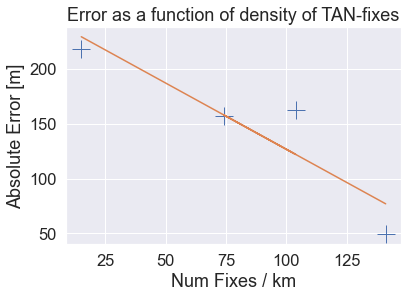

In [287]:


#x --> number of fixes per km (dive a, e, f, g)
#y --> error in absolute (meters)
x = []
y = []
for i in range(0,len(tan_update_log)):
    x.append((tan_update_log[i]+tan_update_log_SF[i])/(dive_range[i]/1000))
    y.append(mf_tan_composite_error[i]/100*dive_range[i])
x = np.array(x)
y = np.array(y)
m,b = np.polyfit(x,y,1)
plt.figure()
plt.plot(x,y, '+',markersize=18)
plt.plot(x, m*x + b)
plt.xlabel('Num Fixes / km')
plt.ylabel('Absolute Error [m]')
plt.title('Error as a function of density of TAN-fixes')

## Sensitivity Test Analysis

ValueError: x and y must have same first dimension, but have shapes (14,) and (1,)

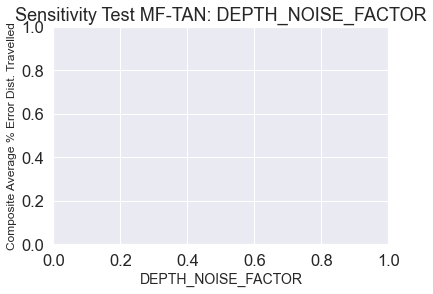

In [261]:
# plt.figure()
# plt.title('Sensitivity Test DVL-ODO: %s'% sensitivity_test_label)
# plt.xlabel('%s'%sensitivity_test_label, fontsize=14)
# plt.ylabel('Composite Average % Error Dist. Travelled', fontsize=12)
# plt.plot(sensitivity_test_list, dvl_odo_composite_error_list)
# plt.grid(True)

plt.figure()
plt.title('Sensitivity Test MF-TAN: %s'% sensitivity_test_label)
plt.xlabel('%s'%sensitivity_test_label, fontsize=14)
plt.ylabel('Composite Average % Error Dist. Travelled', fontsize=12)
plt.plot(sensitivity_test_list, mf_tan_composite_error_list)
plt.legend(['Composite'])

plt.figure()
plt.plot(sensitivity_test_list, mf_tan_error_a, sensitivity_test_list, mf_tan_error_e, sensitivity_test_list, mf_tan_error_f, sensitivity_test_list, mf_tan_error_g)
plt.legend(['Dive A', 'Dive E', 'Dive F', 'Dive G'])
plt.title('Sensitivity Test MF-TAN: %s'% sensitivity_test_label)
plt.ylabel('% Error Dist. Travelled', fontsize=12)
plt.xlabel('%s'%sensitivity_test_label, fontsize=14)

sensitivity_test_list = np.array(sensitivity_test_list)
mf_tan_composite_error_list = np.array(mf_tan_composite_error_list)
optimal_tan_val = sensitivity_test_list[mf_tan_composite_error_list.argmin()]

print('Optimal value for MF-TAN: %.2f' % optimal_tan_val)
# dvl_odo_composite_error_list = np.array(dvl_odo_composite_error_list)
# optimal_dvl_val = sensitivity_test_list[dvl_odo_composite_error_list.argmin()]
# optimal_avg = (optimal_dvl_val + optimal_tan_val)/ 2
# print('Optimal value for DVL-ODO: %.2f \n\r Optimal value for MF-TAN: %.2f \n\r Average value of: %f' % (optimal_dvl_val, optimal_tan_val,optimal_avg))

In [ ]:
plt.figure()
plt.plot(sensitivity_test_list, mf_tan_error_a)
plt.title('Sensitivity Test MF-TAN: %s'% sensitivity_test_label)
plt.ylabel('% Error Dist. Travelled', fontsize=12)
plt.xlabel('%s'%sensitivity_test_label, fontsize=14)
plt.legend(['Dive A'])